In [1]:
import warnings

warnings.filterwarnings(action='ignore')

import os
import time
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'horses_or_humans', split= ('train[:80%]', 'train[10%:]', 'test'),
    with_info=True, as_supervised=True)

In [2]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>


In [3]:
get_label_name = metadata.features['label'].int2str

def show_images(dataset):
    for image, label in dataset.take(10):
        plt.figure()
        plt.imshow(image)
        plt.title(get_label_name(label))

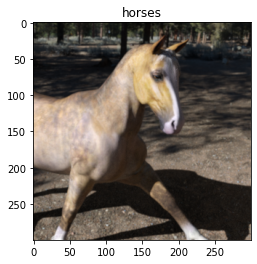

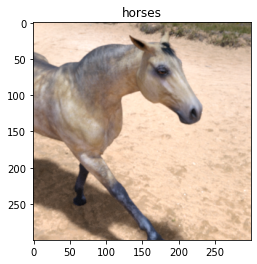

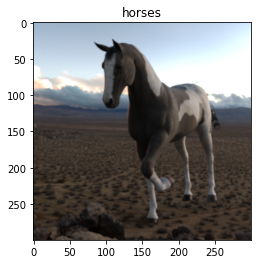

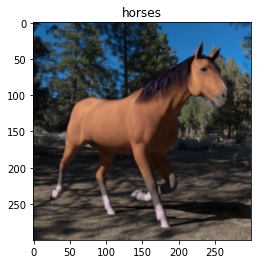

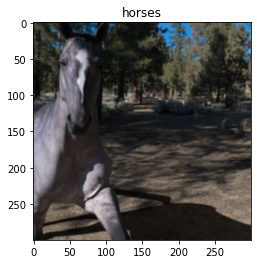

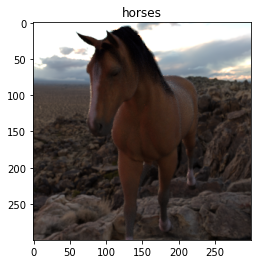

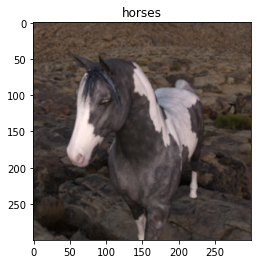

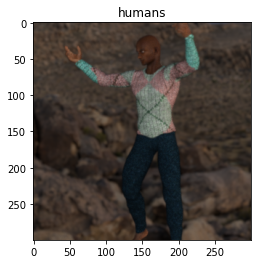

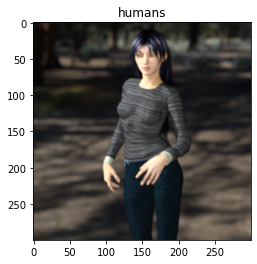

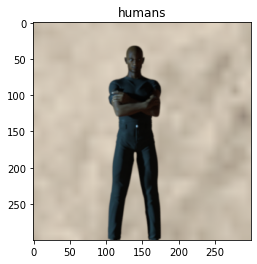

In [4]:
show_images(raw_train)

In [5]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    return image, label

In [6]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

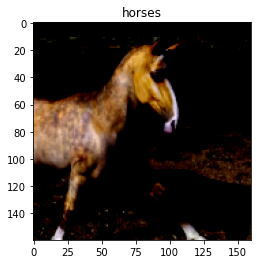

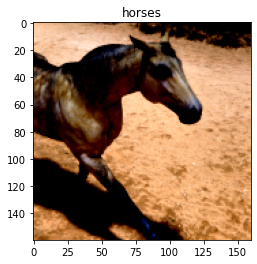

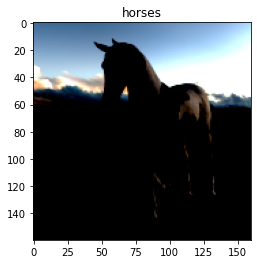

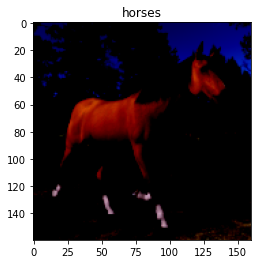

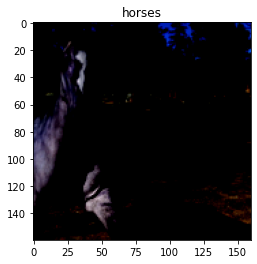

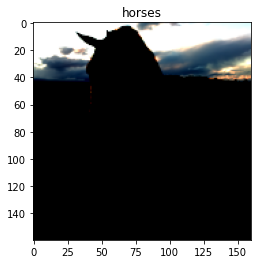

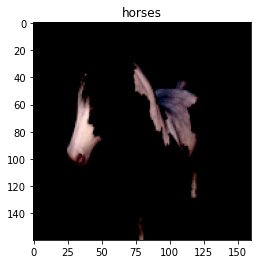

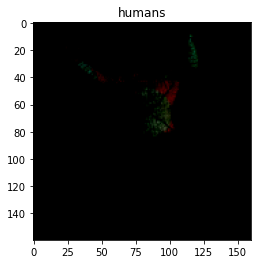

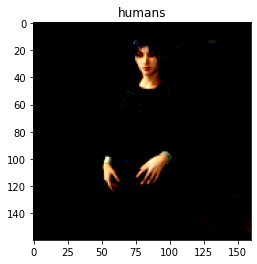

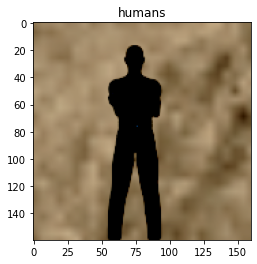

In [7]:
show_images(train)

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 2000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [9]:
print (train_batches)
print (validation_batches)
print (test_batches)

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>
<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>


In [10]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 5s 1us/step


In [11]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [13]:
for image_batch, label_batch in train_batches.take(1):
    pass

In [14]:
print (image_batch.shape)

(32, 160, 160, 3)


In [15]:
feature_batch = base_model(image_batch)

print(feature_batch.shape)

(32, 5, 5, 1280)


In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

print(prediction_batch.shape)

(32, 1)


In [18]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10 for weight in SPLIT_WEIGHTS
)

In [22]:
print (num_train, num_val, num_test)

821.6 102.7 102.7


In [23]:
initial_epochs = 20
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 4

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

4/4 [==============================] - 1s 264ms/step - loss: 3.8957 - accuracy: 0.5625


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.90
initial accuracy: 0.56


In [25]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/20
26/26 [==============================] - 5s 178ms/step - loss: 3.1132 - accuracy: 0.6156 - val_loss: 2.7933 - val_accuracy: 0.6439
Epoch 2/20
26/26 [==============================] - 2s 76ms/step - loss: 2.2588 - accuracy: 0.6800 - val_loss: 2.3550 - val_accuracy: 0.6797
Epoch 3/20
26/26 [==============================] - 2s 73ms/step - loss: 1.9830 - accuracy: 0.7190 - val_loss: 1.7763 - val_accuracy: 0.7294
Epoch 4/20
26/26 [==============================] - 2s 74ms/step - loss: 1.4593 - accuracy: 0.7713 - val_loss: 1.2793 - val_accuracy: 0.7857
Epoch 5/20
26/26 [==============================] - 2s 74ms/step - loss: 1.2749 - accuracy: 0.8005 - val_loss: 1.0476 - val_accuracy: 0.8301
Epoch 6/20
26/26 [==============================] - 2s 74ms/step - loss: 1.0834 - accuracy: 0.8175 - val_loss: 0.9677 - val_accuracy: 0.8463
Epoch 7/20
26/26 [==============================] - 2s 74ms/step - loss: 0.9466 - accuracy: 0.8370 - val_loss: 0.8071 - val_accuracy: 0.8647
Epoch 8/20
2